In [1]:
import os
import sys
import pandas as pd, geopandas as gp, numpy as np
import logging
import getpass
from arcgis import GIS
# from pandas_profiling import ProfileReport


user = getpass.getuser()

DVUTILS_LOCAL_CLONE_PATH = f"/Users/{user}/Documents/GitHub/dvutils"
sys.path.insert(0, DVUTILS_LOCAL_CLONE_PATH)
from utils_io import *

Info: Found credentials at: /Users/jcroff/Library/CloudStorage/Box-Box/dvutils-creds-jcroff.json


In [2]:
def flag_mult_columns(dataframe, dictionary, standard_deviation):
    for key, value in dictionary.items():
        this_mean = dataframe[key].mean()
        this_sd = dataframe[key].std()
        cond = this_mean + (standard_deviation * this_sd)
        dataframe[value] = 0
        dataframe.loc[dataframe[key] > cond, value] = 1

# Read pre-canned table from CSV

In [15]:
acs_df = pd.read_csv('Data/epc_lwr_threshold_acs2022.csv')
acs_df

,tract_geoid,county_fip,tot_pop_poc,tot_pop_se,tot_pop_po,tot_pop_ci,tot_pop_ov,tot_hh,tot_fam,pop_poc,...,spfam_1_4,lep_1_4,disab_1_4,below2_1_4,hus_re_1_4,zvhh_1_4,epc_2050p,epc_2050_lwr_thres,epc_class,epc_change
0,6001400100,1,3269,3269,3248,3269,3136,1377,891,1014,...,0,0,1,0,0,0,0,0,NaN,not_an_epc
1,6001400200,1,2147,2147,2147,2147,1978,876,516,647,...,0,0,0,0,0,0,0,0,NaN,not_an_epc
2,6001400300,1,5619,5619,5592,5619,5492,2638,1100,2329,...,1,0,0,0,0,1,0,0,NaN,not_an_epc
3,6001400400,1,4278,4278,4226,4259,3956,1760,799,1538,...,0,0,0,0,0,1,0,0,NaN,not_an_epc
4,6001400500,1,3949,3949,3941,3949,3791,1679,831,2311,...,0,0,0,1,1,0,0,0,NaN,not_an_epc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1767,6097154305,97,2173,2173,2076,2152,2120,794,543,604,...,0,0,0,0,0,0,0,0,NaN,not_an_epc
1768,6097154306,97,1633,1633,1633,1633,1574,783,369,404,...,0,0,0,0,0,0,0,0,NaN,not_an_epc
1769,6097154307,97,783,783,783,783,779,370,221,170,...,0,0,1,1,0,0,0,0,NaN,not_an_epc
1770,6097154308,97,935,935,935,935,919,463,296,218,...,0,0,1,1,0,0,0,0,NaN,not_an_epc


In [18]:
# calculate share of total population within epcs

acs_df.query("epc_2050p == 1")["tot_pop_poc"].sum() / acs_df["tot_pop_poc"].sum()


0.19689071711687706

In [17]:
acs_df.query("epc_2050_lwr_thres == 1")["tot_pop_poc"].sum() / acs_df["tot_pop_poc"].sum()

0.26254806211071513

In [5]:
acs_df.columns

Index(['tract_geoid', 'county_fip', 'tot_pop_poc', 'tot_pop_se', 'tot_pop_po',
       'tot_pop_ci', 'tot_pop_ov', 'tot_hh', 'tot_fam', 'pop_poc',
       'pop_over75', 'pop_spfam', 'pop_lep', 'pop_below2', 'pop_disabi',
       'pop_hus_re', 'pop_zvhhs', 'pct_poc', 'pct_over75', 'pct_spfam',
       'pct_lep', 'pct_below2', 'pct_disab', 'pct_hus_re', 'pct_zvhhs',
       'poc_1_2', 'over75_1_2', 'spfam_1_2', 'lep_1_2', 'disab_1_2',
       'below2_1_2', 'hus_re_1_2', 'zvhh_1_2', 'epc_2050p', 'epc_class'],
      dtype='object')

In [6]:
def total_pop_in_epcs(df, sd_multiplier):
    cols_dict_halfsd = {
        "pct_over75": "over75_1_2",
        "pct_poc": "poc_1_2",
        "pct_spfam": "spfam_1_2",
        "pct_disab": "disab_1_2",
        "pct_lep": "lep_1_2",
        "pct_below2": "below2_1_2",
        "pct_zvhhs": "zvhh_1_2",
        "pct_hus_re": "hus_re_1_2",
    }

    flag_mult_columns(df, cols_dict_halfsd, sd_multiplier)

    halfsd_cols_list = cols_dict_halfsd.values()
    df["count_1_2"] = df[halfsd_cols_list].sum(axis=1)

    halfsd_remain = ["spfam_1_2", "disab_1_2", "lep_1_2", "over75_1_2", "zvhh_1_2", "hus_re_1_2"]
    halfsd_cond = ((df["poc_1_2"] == 1) & (df["below2_1_2"] == 1)) | (
        (df["below2_1_2"] == 1) & (df[halfsd_remain].sum(axis=1) >= 3)
    )
    df["epc50p_1_2"] = np.where(halfsd_cond, 1, 0)

    return df.loc[df['epc50p_1_2'] == 1, 'tot_pop_poc'].sum()

In [7]:
def le_pop_in_epcs(df, sd_multiplier):
    cols_dict_halfsd = {
        "pct_over75": "over75_1_2",
        "pct_poc": "poc_1_2",
        "pct_spfam": "spfam_1_2",
        "pct_disab": "disab_1_2",
        "pct_lep": "lep_1_2",
        "pct_below2": "below2_1_2",
        "pct_zvhhs": "zvhh_1_2",
        "pct_hus_re": "hus_re_1_2",
    }

    flag_mult_columns(df, cols_dict_halfsd, sd_multiplier)

    halfsd_cols_list = cols_dict_halfsd.values()
    df["count_1_2"] = df[halfsd_cols_list].sum(axis=1)

    halfsd_remain = ["spfam_1_2", "disab_1_2", "lep_1_2", "over75_1_2", "zvhh_1_2", "hus_re_1_2"]
    halfsd_cond = ((df["poc_1_2"] == 1) & (df["below2_1_2"] == 1)) | (
        (df["below2_1_2"] == 1) & (df[halfsd_remain].sum(axis=1) >= 3)
    )
    df["epc50p_1_2"] = np.where(halfsd_cond, 1, 0)

    return df.loc[df['epc50p_1_2'] == 1, 'pop_below2'].sum()

In [8]:
mults = [x / 10 for x in range(-20, 21)]
total_pops = [total_pop_in_epcs(acs_df, x) for x in mults]

# total_pops

<Axes: xlabel='mult'>

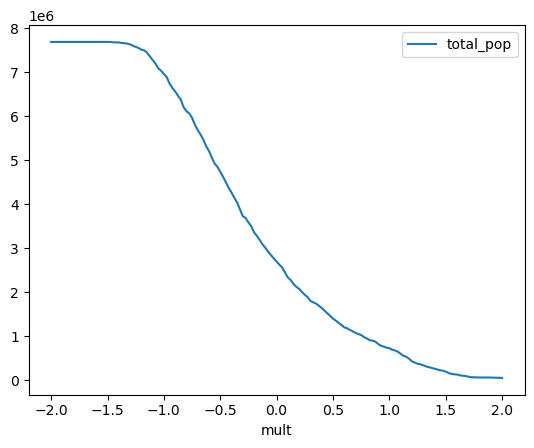

In [9]:
mults = np.arange(-2.0, 2.01, 0.025)
total_pops = [total_pop_in_epcs(acs_df, x) for x in mults]

viz_df = pd.DataFrame({
    'mult': mults,
    'total_pop': total_pops
})

viz_df.plot.line(x='mult', y='total_pop')

In [10]:
viz_df[viz_df['total_pop'].between(500000, 2000000)]

,mult,total_pop
90,0.250,1939699
91,0.275,1888433
92,0.300,1801600
93,0.325,1768484
94,0.350,1740330
95,0.375,1690971
96,0.400,1641263
97,0.425,1579208
98,0.450,1520613
99,0.475,1463195


<Axes: xlabel='mult'>

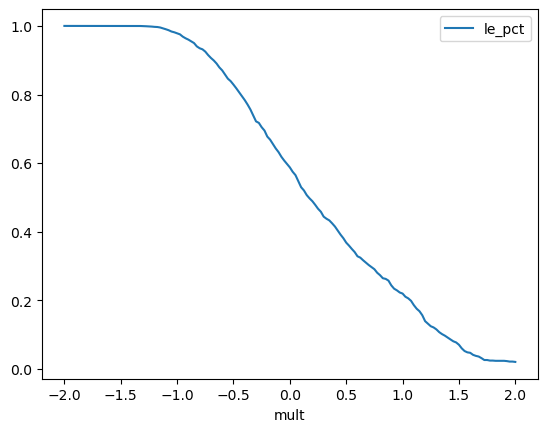

In [11]:
le_pops = [le_pop_in_epcs(acs_df, x) for x in mults]

viz_df = pd.DataFrame({
    'mult': mults,
    'le_pop': le_pops
})

viz_df['le_pct'] = viz_df['le_pop'] / acs_df['pop_below2'].sum()

viz_df.plot.line(x='mult', y='le_pct')

In [12]:
viz_df[viz_df['le_pct'].between(0.3, 0.6)]

,mult,le_pop,le_pct
79,-2.500000e-02,822180,0.597459
80,-7.105427e-15,808477,0.587502
81,2.500000e-02,790902,0.574730
82,5.000000e-02,777474,0.564973
83,7.500000e-02,752786,0.547032
84,1.000000e-01,728883,0.529663
85,1.250000e-01,715921,0.520243
86,1.500000e-01,697128,0.506587
87,1.750000e-01,684092,0.497114
88,2.000000e-01,672755,0.488876
